In [1]:
# Reference
# https://yurimkoo.github.io/python/2019/09/14/connect-db-with-python.html

from dotenv import load_dotenv
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

os.chdir(os.path.dirname(os.getcwd()))

from functions.pubgapi import get_tournament_info
from functions.pubgapi import get_match_info
from functions.pubgapi import get_match_participant_single
from functions.pubgapi import z_normalization
from functions.pubgapi import standard_scaling

os.chdir("./example")

# Load api key & RDS info (endpoint="rds 엔드포인트", dbname="db 이름", username="마스터 사용자 이름", password="rds 비밀번호")
load_dotenv()
api_key = os.environ.get("API_KEY")
endpoint = os.environ.get("AWS_endpoint")
dbname = os.environ.get('AWS_dbname')
username = os.environ.get("AWS_username")
password = os.environ.get("AWS_password")

In [2]:
# 결측치 확인 함수
def check_missing_value(filename, df):
    # 결측치가 발생한 부분에서 log 파일(.csv) 생성
    if (df.isnull().sum()).sum() != 0:
        data.to_csv(f"./Train_data/Error_log/{filename}.csv")
        raise Exception(f"Missing value: {(df.isnull().sum()).sum()}\nError_log: pubg_api/Data/Error_log/{filename}.csv")

In [3]:
# tournament_info 불러오기
tournament_info = get_tournament_info(api_key)
check_missing_value('tournament_info', tournament_info)

# index 설정 및 해당 인덱스의 tournament_id 값 불러오기
tournament_index = 3
tournament_name = tournament_info["id"][tournament_index]
tournament_createdAt = tournament_info["createdAt"][tournament_index]

# cur_match_info(Current match info) 불러오기
cur_match_info = get_match_info(api_key, tournament_name)

# match_participant_single 불러오기
match_index = 2
match_participant_single = get_match_participant_single(api_key, cur_match_info["matchId"][match_index])
check_missing_value(cur_match_info["matchId"][match_index], match_participant_single)

# Z-score normalization 수행
# data = z_normalization(match_participant_single)
data = match_participant_single

'''
    해당 경로에 train_match_data.csv가 없으면, 파일 생성
    해당 경로에 train_match_data.csv가 있으면, 현재 내용을 해당 파일에 추가

'''

if os.path.isfile("./Train_data/train_match_data.csv"):
    # Load train_data & append new data(row)
    train_data = pd.read_csv(f"./Train_data/train_match_data.csv")
    train_data.drop(["Unnamed: 0"], axis = 1, inplace = True)

    train_data = pd.concat([train_data, data], ignore_index=True)
    train_data.to_csv(f"./Train_data/train_match_data.csv")
else:
    data.to_csv(f"./Train_data/train_match_data.csv")

In [4]:
data = pd.read_csv(f"./Train_data/train_match_data.csv")
data.drop(["Unnamed: 0", "match_id", "player_id"], axis = 1, inplace = True)

In [5]:
# VIF

z_label = (["dbnos", "assists", "boosts", "damage_dealt", "heals", "kill_streaks", "kills", "longest_kill", "revives", "ride_distance", "swim_distance", "headshot_kills", "vehicle_destroys", "walk_distance", "weapons_acquired"])
data_corr = data[z_label]

vif = pd.DataFrame()
vif["features"] = data_corr.columns
vif["VIF Factor"] = [variance_inflation_factor(data_corr.values, i) for i in range(data_corr.shape[1])]
vif

,features,VIF Factor
0,dbnos,9.698630
1,assists,4.378048
2,boosts,5.568205
3,damage_dealt,14.033961
4,heals,2.806419
5,kill_streaks,11.403764
6,kills,21.842441
7,longest_kill,3.737839
8,revives,1.834433
9,ride_distance,5.047513


<AxesSubplot:>

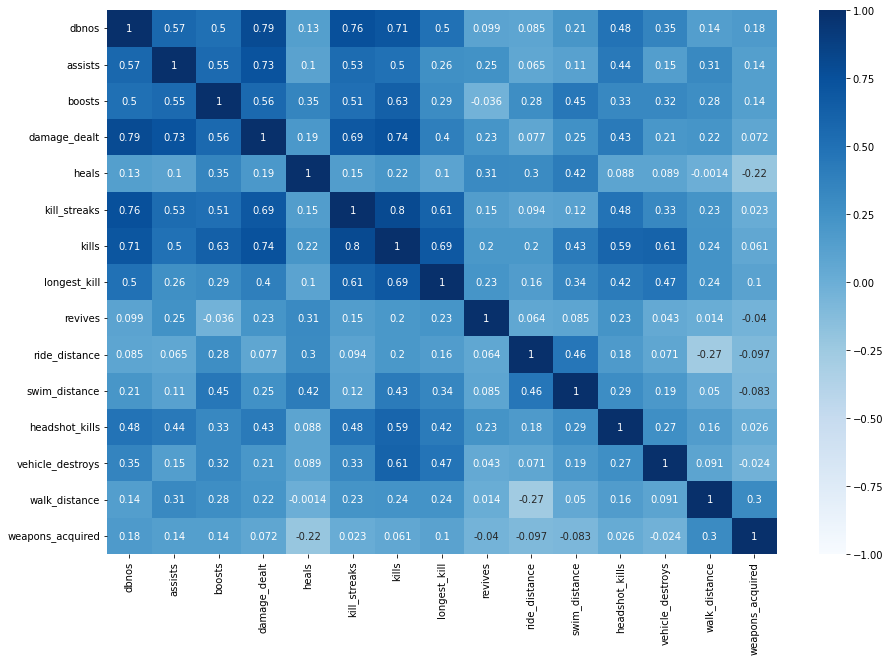

In [6]:
# https://tjansry354.tistory.com/13

plt.rcParams['figure.figsize']=(15,10)
sb.heatmap(data_corr.corr(), annot=True, cmap='Blues', vmin = -1, vmax = 1)

훈련 세트 정확도 : 1.000
테스트 세트 정확도 : 0.800
특성 중요도 : 
[0.02380267 0.1484788  0.05127233 0.09822954 0.02570912 0.06153784
 0.0779068  0.112802   0.0629058  0.13954604 0.00226648 0.02132945
 0.00774575 0.11732685 0.04914053]


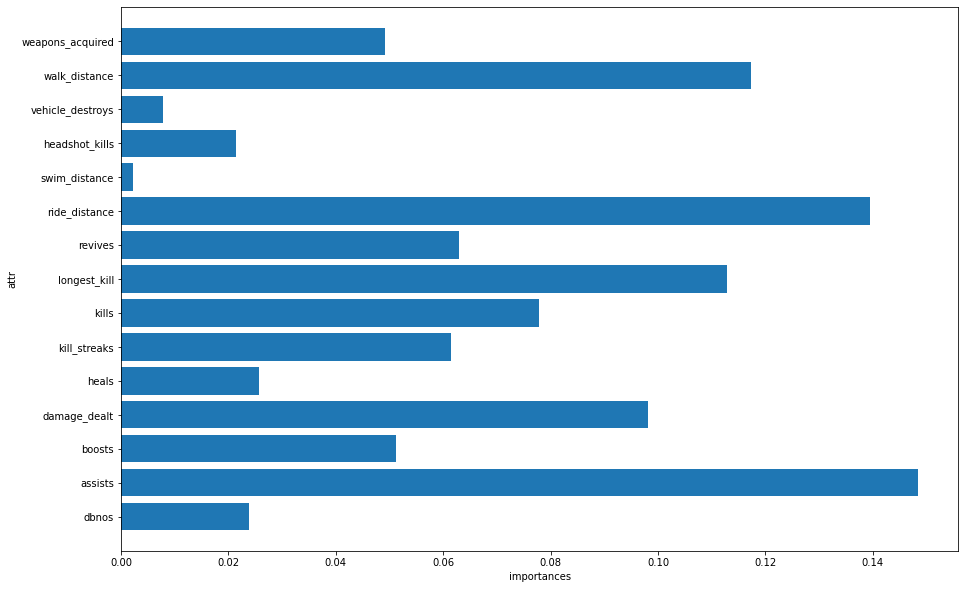

In [7]:
X = data[z_label]
y = data["win"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train,y_train)

print("훈련 세트 정확도 : {:.3f}".format(forest.score(X_train,y_train)))
print("테스트 세트 정확도 : {:.3f}".format(forest.score(X_test,y_test)))

print("특성 중요도 : \n{}".format(forest.feature_importances_))

# 특성 중요도 시각화 하기
def plot_feature_importances_cancer(model):
    n_features = len(z_label)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), z_label)
    plt.xlabel("importances")
    plt.ylabel("attr")
    plt.ylim(-1, n_features)
plt.show()

plot_feature_importances_cancer(forest)

In [8]:
mvp_feature = (forest.feature_importances_)*data[z_label]
data["mvp_feature"] = mvp_feature.sum(axis=1)

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

data.sort_values(["mvp_feature"], ascending=False)

,team_rank,dbnos,assists,boosts,damage_dealt,headshot_kills,heals,kill_streaks,kills,longest_kill,revives,ride_distance,swim_distance,vehicle_destroys,walk_distance,weapons_acquired,round_point,win,mvp_feature
36,2,2,2,14,544.111400,2,6,1,6,172.963780,0,8586.5990,70.622635,1,1382.84920,3,12,0,1435.533215
37,2,2,2,5,354.541400,0,8,1,2,372.594570,2,8061.9976,69.221100,0,1380.84420,4,8,0,1365.389015
55,7,0,0,1,27.524298,0,0,0,0,0.000000,0,8533.6420,0.000000,0,803.49805,6,1,0,1288.157671
38,2,3,0,12,253.091950,1,7,1,2,133.274700,0,7763.0586,78.368065,0,1186.69290,5,8,0,1263.958440
52,7,0,1,5,45.683540,0,0,0,0,0.000000,0,7785.6606,0.000000,0,878.06500,3,1,0,1194.518454
48,7,1,1,4,0.000000,0,4,0,0,0.000000,0,7592.2900,0.000000,0,867.08575,6,1,0,1161.981506
32,2,1,0,1,126.460000,0,2,1,1,174.907790,2,7227.7920,0.000000,0,613.79250,4,7,0,1113.364472
16,5,2,2,7,530.776250,1,2,2,3,218.789200,1,6270.4390,0.000000,0,1005.00134,3,6,0,1071.089690
35,2,1,0,1,33.220010,1,1,1,1,147.993120,0,6901.3296,0.000000,0,578.80176,3,7,0,1051.328301
34,2,0,1,2,88.829994,0,5,0,0,0.000000,0,6656.8037,0.000000,0,882.39166,5,6,0,1041.809841
